## IMPORT LIBS 

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
import glob
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## HELPERS

In [173]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
      if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
      else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),block_norm= 'L2-Hys',

                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
 #######################################################   

def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

 ####################################################### 
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

 ####################################################### 
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

 ####################################################### 
    
    
# Function to Convert image to desired color space
def convert_image(image, cspace):
    '''''
    Param: input image in RGB format
    Param: Desired image colorspace
    Returns: image in desired colorspace
    '''''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    return feature_image

 ####################################################### 
    
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

####################################################### 
    
def getCarData():
    cars = []
    ## get small subset from lesson. works well
    vehicles_images2 = glob.glob( './vehicles_smallset/*cars*/*.jpeg')
    ## get proposed vehicle data
    vehicles_images = glob.glob( './vehicles/*TI*/*.png')

    for image in vehicles_images:
        onecar = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        cars.append(onecar)

    for image in vehicles_images2:
        onecar = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        cars.append(onecar)

    return list(cars)

 ####################################################### 

def getNonCarData():

    notcars = []
    nonvehicles_images2 = glob.glob( './non-vehicles_smallset/*cars*/*.jpeg')
    nonvehicles_images = glob.glob( './non-vehicles/*TI*/*.png')
    nonvehicles_images_extras = glob.glob( './non-vehicles/*TI*/*.png')

    for image in nonvehicles_images:
            onecar = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
            notcars.append(onecar)
            
    for image in nonvehicles_images2:
            onecar = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
            notcars.append(onecar)

    for image in nonvehicles_images_extras:
            onecar = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
            notcars.append(onecar)
            
    return list(notcars)

 ####################################################### 
    
def extract_features(img, params):
    file_features = []
    feature_image = convert_image(img, params.color_space)    
    if params.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=params.spatial_size)
        file_features.append(spatial_features)
    if params.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=params.hist_bins)
        file_features.append(hist_features)
    if params.hog_feat == True:
        if params.hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(

                    feature_image[:,:,channel], 
                    params.orient, 
                    params.pix_per_cell, 
                    params.cell_per_block, 
                    vis=False, 
                    feature_vec=True)                                     
                                )
            hog_features = np.ravel(hog_features)  
        else:
            hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params.orient, 
                        params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features)

        return np.concatenate(file_features)
 
 ###################################

def show_hog(vehicle, non_vehicle, params):
    _,vehicle_hog = get_hog_features(vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    _,non_vehicle_hog = get_hog_features(non_vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Vehicle')
    ax1.imshow(vehicle, cmap='gray')
    ax2.set_title('Vehicle hog')
    ax2.imshow(vehicle_hog, cmap='gray')
    ax3.set_title('Non-vehicle')
    ax3.imshow(non_vehicle, cmap='gray')
    ax4.set_title('Non-vehicle hog')
    ax4.imshow(non_vehicle_hog, cmap='gray')
    

    ###################################
    
class  Settings ():
    color_space='RGB'
    spatial_size=(32, 32)
    hist_bins=8
    orient=9
    pix_per_cell=8
    cell_per_block=2
    hog_channel=0
    hist_range = (0, 256)
    spatial_feat=True
    hist_feat=True
    hog_feat=True
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=8, orient=9, 
                 pix_per_cell=8, cell_per_block=2, hog_channel=0, scale = 1.5,hist_range = (0, 256),
                 spatial_feat=True, hist_feat=True, hog_feat=True):
        # HOG parameters
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.scale = scale
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.hist_range = hist_range
        
 ######################################## 

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

###################################

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

###################################

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

###################################

def heat_threshold(img, threshold, svc, X_scaler, windows_list, params):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

###################################

def find_cars(img, ystart, ystop, svc, scaler, params, cells_per_step = 1):
    
    draw_img = np.copy(img)
    cspace = params.color_space
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    if params.scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/params.scale), np.int(imshape[0]/params.scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=params.spatial_size)
            hist_features = color_hist(subimg, nbins=params.hist_bins, bins_range=params.hist_range)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*params.scale )
                ytop_draw = np.int(ytop*params.scale )
                win_draw = np.int(window*params.scale )
                # draw boxes + Add to the list
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows


## LOAD DATA

In [167]:

vehicles = getCarData()
non_vehicles = getNonCarData()

print(len(vehicles))
print(len(non_vehicles))
     

9988
8925


## PROFILE DATA

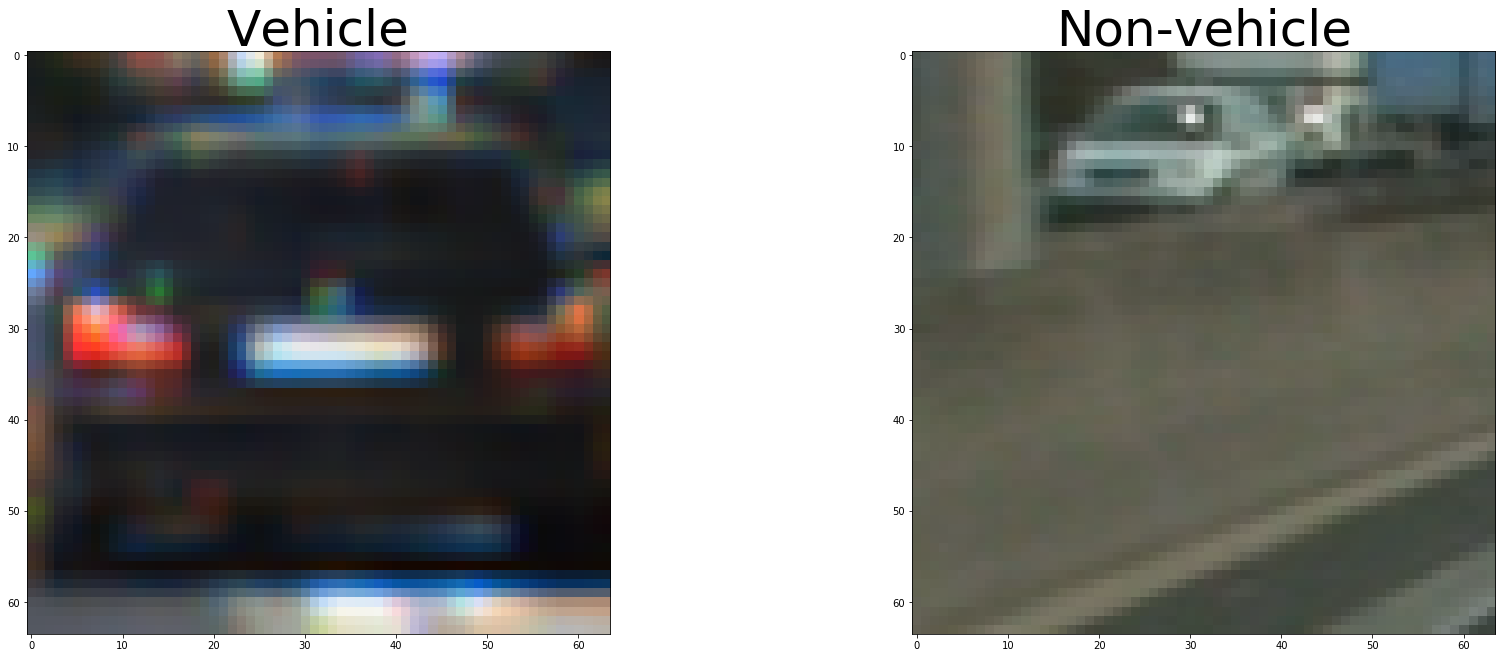

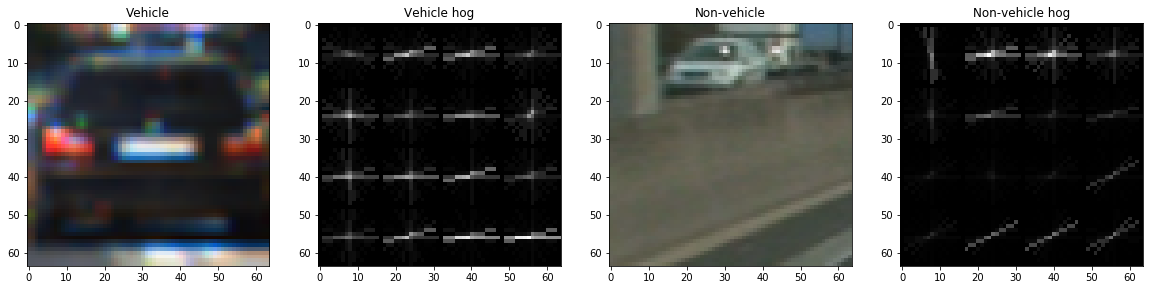

In [169]:
image1 = random.choice(vehicles)
image2 = random.choice(non_vehicles)

############################################
show_images(image1, "Vehicle", image2, "Non-vehicle")

show_hog(image1, image2, params)


## SETTINGS (PARAMETERS TO BE USED)

In [212]:
params = Settings(
    color_space = 'YCrCb',
    spatial_size = (32, 32),
    orient = 12,
    pix_per_cell = 16,
    cell_per_block = 2,
    hog_channel = 'ALL',
    hist_bins = 32,
    scale = 1.25,
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True
)

## CLASSIFIER (LINEAR SVM)

In [126]:
# sample_size = 8500
# # cars2 = vehicles[0:sample_size]
# # notcars2 = non_vehicles[0:sample_size]
# randomindex = np.random.randint(0, 8500, sample_size)                            
# cars2 = np.array(vehicles)[randomindex]
# notcars2 = np.array(non_vehicles) [randomindex]
# cars2 = vehicles
# notcars2 = non_vehicles

car_features = list(map(lambda img: extract_features(img, params), vehicles))
notcar_features = list(map(lambda img: extract_features(img, params), non_vehicles))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4464
14.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9937


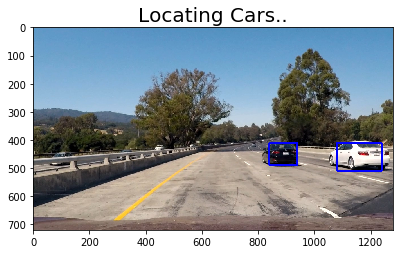

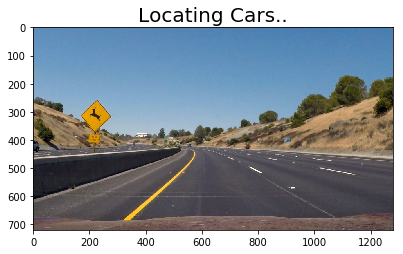

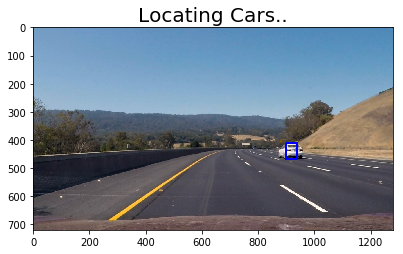

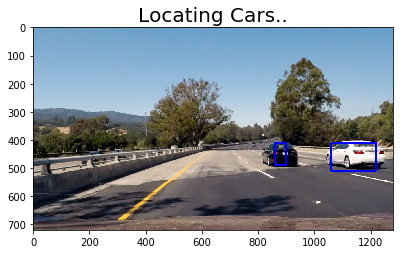

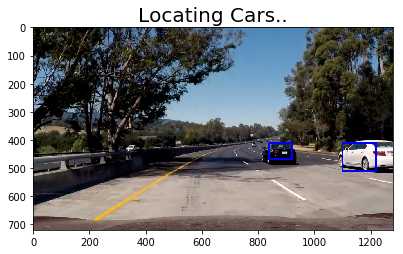

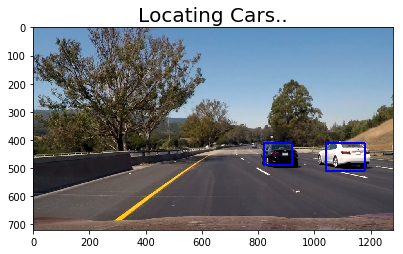

In [213]:
ystart = 350
ystop = 656
threshold = 3


##################################
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test1_MARKED.jpg")

img = cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test2_MARKED.jpg")

img = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test3_MARKED.jpg")


img = cv2.cvtColor(cv2.imread(test_images[3]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test4_MARKED.jpg")


img = cv2.cvtColor(cv2.imread(test_images[4]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test5_MARKED.jpg")

img = cv2.cvtColor(cv2.imread(test_images[5]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, params)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
f, (ax1) = plt.subplots(1, figsize=(5, 5))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Locating Cars..', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("test6_MARKED.jpg")

## VIDEO PIPELINE

In [189]:
def  pipeline(img):
    
    ystart = 350
    ystop = 656
    threshold = 5  ## setting a diff threshold for video to eliminate false pos
    
    car_windows = find_cars(img, ystart, ystop, svc, X_scaler, params)
    draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
    
    return draw_img

def process_image(img):
    return pipeline(img)

In [145]:
white_output = 'project_video_op.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(40,45)  ## for testing
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_op.mp4
[MoviePy] Writing video project_video_op.mp4


100%|█████████▉| 1260/1261 [07:03<00:00,  2.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_op.mp4 

CPU times: user 6min 55s, sys: 9.88 s, total: 7min 5s
Wall time: 7min 3s


## DISPLAY

In [210]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## EXTRAS

In [196]:
%matplotlib qt
# img = cv2.imread(camera_cal_images[8]) 
# plt.imshow(img)

# prepare object points
nx = 9
ny = 6

#Prep Object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

camera_cal_images = glob.glob('camera_cal/calibration*.jpg') 

#Iterate over images
for idx, img in enumerate(camera_cal_images):
    fname = img
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

In [197]:
import pickle
%matplotlib inline

for idx, img in enumerate(camera_cal_images):
    fname = img
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('camera_cal\\undist_'+ fname.split('\\')[1] ,dst)

In [206]:
from CarNDAdvancedLaneLines import *
import pickle

# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump(dist_pickle, open('dist_pickle.p', 'wb'))

dist_pickle = pickle.load(open('dist_pickle.p', 'rb'))

In [207]:
def process_image(image):
  
    M = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    coeff_pickle = pickle.load(open("co-officients.p", 'rb'))    
    shadesFlag = coeff_pickle["shadesFlag"]   
    
    if(shadesFlag == 0) :
             src = np.float32([[210, 710],[600,453],[680, 453],[880,710]]) 
             dst = np.float32([[300, 710],[300, 0],[880, 0],[880,710]])
    else:
             src = np.float32([[210, 710],[600,453],[680, 453],[1100,710]]) 
             dst = np.float32([[300, 710],[300, 0],[1100, 0],[1100,710]])
 
    result = pipeline(image, src, dst, M, dist)
    
    return result

In [208]:
reset()
###############

white_output = 'project_video_op_final.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video_op.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_op_final.mp4
[MoviePy] Writing video project_video_op_final.mp4


100%|█████████▉| 1260/1261 [55:14<00:02,  2.63s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_op_final.mp4 

CPU times: user 29min 41s, sys: 43.1 s, total: 30min 24s
Wall time: 55min 15s


In [211]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))